    - 사진파일 다운로드 및 압축 해제

In [1]:
import os 
from urllib import request as req 
import tarfile
import zipfile
import sys 

def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

main_directory = "./data_set/"
cifar_10_directory = main_directory+"cifar_10/"
if not os.path.exists(main_directory):
    os.makedirs(main_directory)

    url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = url.split('/')[-1]
    file_path = os.path.join(main_directory, filename)
    zip_cifar_10 = file_path
    file_path, _ = req.urlretrieve(url=url, filename=file_path, 
                                  reporthook=_print_download_progress)

    if file_path.endswith(".zip"):
        zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
    elif file_path.endswith((".tar.gz", ".tgz")):
        tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)

    os.rename(main_directory+"./cifar-10-batches-py", cifar_10_directory)
    os.remove(zip_cifar_10)

     - Image Data / Label loads

In [2]:
import pickle 
import numpy as np 

folder_name = "cifar_10"

f = open('./data_set/'+folder_name+'/data_batch_1', 'rb')
data_dict = pickle.load(f, encoding='latin1')
X, Y = data_dict["data"], data_dict["labels"]
for i in range(1, 5): 
    f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
    data_dict = pickle.load(f, encoding='latin1')
    X = np.concatenate((X, data_dict["data"]), axis=0)
    Y += data_dict["labels"]   
X.shape, len(Y)

((50000, 3072), 50000)

    - "data_X"에 존재하는 데이터를 확인해 보면,,
* 3072 = 32 * 32 * 3
* 이는 32x32 크기의 사진(r,g,b 3가지 특성을 또 가지는(컬러) 숫자 0~255 사이의 숫자로 이루어진 배열)
* 현재 평평하게(1차원)의 배열을 가지고 있으므로 이를 <b>사진 차원에 맞도록 바꾸는 과정</b>이 필요!

In [3]:
data_X = X.reshape(X.shape[0], 3, 32, 32)
data_X.shape

(50000, 3, 32, 32)

    - Preprocessing

 * 이미지 데이터를 보면 0 ~ 255 사이의 숫자를 0~1 사이의 숫자로 변환하면 Overfitting 방지, 학습이 잘되는 효과가 있으므로 모든 값들을 나누어 준다.
 * input_shape : 나중에 모델 초기 입력 크기 지정할때 쓰임

In [4]:
data_X = data_X.transpose(0, 2, 3, 1) 
data_X = data_X.astype('float32')
data_X /= 255
input_shape = data_X.shape[1:]
input_shape

(32, 32, 3)

 * Label data를 categorical(Label Encoding)하는 과정을 거쳐서 0 ~ 9 사이의 숫자를 길이가 10인 배열로 변환하여 준다.
 ex) 3 -> [0,0,0,1,0,0,0,0,0,0,0]

In [5]:
from keras.utils import to_categorical
data_Y = np.reshape(Y, (len(Y), 1))
data_Y = to_categorical(data_Y, 10)
data_Y.shape

Using TensorFlow backend.


(50000, 10)

* Validation을 위한 데이터를 7/3 비율로 나눈다.
* stratify: Label값인 data_Y의 각 성분의 비율을 동일하게 적용하여 train/test로 나누도록 설정

In [6]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, 
                                                   test_size=0.3, 
                                                   random_state=0, 
                                                   stratify=data_Y) 
print(train_X.shape, train_Y.shape)
test_X.shape, test_Y.shape

(35000, 32, 32, 3) (35000, 10)


((15000, 32, 32, 3), (15000, 10))

    - Training Model
* 이미지 분류 학습에 필요한 라이브러리 선언

In [7]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf 
import matplotlib.pyplot as plt 

* Model Design
* 각 Conv2D선언 후 kernel_size를 (1,1)로 지정하여 한번 각 필터에 있는 변수의 크기를 절반씩 줄여주어 모델의 크기를 감축시키면서 동일한 학습효과를 불러올 수 있다.
* 각 뉴럴의 변수 초기화는 Relu Activation함수에 효과적인 He Normal 방식을 채택.
* 각 Conv2D 층을 거쳐 MaxPooling Layer를 추가시켜 각 위치의 특징을 잡아준다.
* 마지막으로 Fully Connected Layer을 거쳐 Softmax를 적용시켜 0~9 사이의 Label로 결과를 나타내는 과정을 학습한다.
* 각 층을 통과하고 activation 함수를 거치기 전 BatchNormalization을 통해 Overfitting 방지 및 학습효과에 효율적으로 관리한다.
* Dropout Layer 또한 적용하여 Overfitting을 방지한다.
* Optimizer는 Adam으로, loss function은 categorical_crossentropy로 적용시켰다.

In [8]:
# Model design
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same',
                 input_shape=input_shape, 
                 kernel_initializer='he_normal'))
model.add(Conv2D(filters=32, kernel_size=(1, 1), strides=(1,1), padding='valid', 
                 kernel_initializer='he_normal'))
model.add( BatchNormalization() )
model.add( LeakyReLU(alpha=0.1) )
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same',
                 kernel_initializer='he_normal'))
model.add(Conv2D(filters=16, kernel_size=(1, 1), strides=(1,1), padding='valid', 
                 kernel_initializer='he_normal'))
model.add( BatchNormalization() )
model.add( LeakyReLU(alpha=0.1) )
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, kernel_initializer='he_normal'))
model.add( BatchNormalization() )
model.add( LeakyReLU(alpha=0.1) )
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_normal'))
model.add( BatchNormalization() )
model.add( LeakyReLU(alpha=0.1) )
model.add(Dense(10, activation='softmax'))

opt = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 16)          528       
__________

* 학습할 데이터의 양을 더 늘리기 위해 ImageDataGenerator를 이용하였다. 회전,화면 움직임, 일부 제거, 확대 등을 중심을 축으로 하여 적용시켰으며 이런 적용 이후 normalization을 거친 데이터를 학습시키도록 하였고 validation data또한 동일한 계산과정을 거쳤다. 이후 test_data에도 동일하게 적용시켜야 한다.
* batch 사이즈는 메모리가 최대한 받쳐줄 수 있는 범위로 설정하면 되고 한 epoch당 한꺼번에 많은 batch 크기를 올리기 힘드므로 한 epoch안에서도 분할 학습할 수 있도록 epoch안에도 단계를 나누어 가중치를 조정할 수 있도록 설정하였다.

In [9]:
epochs = 300
batch_size = 256
steps_per_epoch = int(len(data_Y)/batch_size)

datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)
datagen.fit(train_X)
test_X -= datagen.mean
test_X /= (datagen.std + 1e-07)

* validation 정확도를 통한 모델 checkpoint 설정 및 조기종료 설정

In [10]:
model_save_dir = "./model_save/"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
file_path = model_save_dir + "val_acc_{val_acc:.4f}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_acc',
                                verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=40)

In [11]:
# Train
history = model.fit_generator(
                    datagen.flow(train_X, train_Y, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(test_X, test_Y),
                    callbacks=[early_stopping_callback, cb_checkpoint],
                    verbose=2
                    )

Epoch 1/300
 - 31s - loss: 1.8156 - acc: 0.3348 - val_loss: 1.4904 - val_acc: 0.4550

Epoch 00001: val_acc improved from -inf to 0.45500, saving model to ./model_save/val_acc_0.4550.hdf5
Epoch 2/300
 - 26s - loss: 1.5069 - acc: 0.4510 - val_loss: 1.4477 - val_acc: 0.4841

Epoch 00002: val_acc improved from 0.45500 to 0.48413, saving model to ./model_save/val_acc_0.4841.hdf5
Epoch 3/300
 - 27s - loss: 1.4031 - acc: 0.4932 - val_loss: 1.3327 - val_acc: 0.5140

Epoch 00003: val_acc improved from 0.48413 to 0.51400, saving model to ./model_save/val_acc_0.5140.hdf5
Epoch 4/300
 - 38s - loss: 1.3297 - acc: 0.5223 - val_loss: 1.2110 - val_acc: 0.5667

Epoch 00004: val_acc improved from 0.51400 to 0.56673, saving model to ./model_save/val_acc_0.5667.hdf5
Epoch 5/300
 - 32s - loss: 1.2750 - acc: 0.5417 - val_loss: 1.1992 - val_acc: 0.5664

Epoch 00005: val_acc did not improve from 0.56673
Epoch 6/300
 - 33s - loss: 1.2309 - acc: 0.5573 - val_loss: 1.2385 - val_acc: 0.5661

Epoch 00006: val_acc 


Epoch 00056: val_acc did not improve from 0.67693
Epoch 57/300
 - 20s - loss: 0.9315 - acc: 0.6678 - val_loss: 0.9595 - val_acc: 0.6644

Epoch 00057: val_acc did not improve from 0.67693
Epoch 58/300
 - 20s - loss: 0.9248 - acc: 0.6710 - val_loss: 0.9603 - val_acc: 0.6668

Epoch 00058: val_acc did not improve from 0.67693
Epoch 59/300
 - 20s - loss: 0.9264 - acc: 0.6697 - val_loss: 1.0220 - val_acc: 0.6513

Epoch 00059: val_acc did not improve from 0.67693
Epoch 60/300
 - 23s - loss: 0.9194 - acc: 0.6743 - val_loss: 1.0602 - val_acc: 0.6410

Epoch 00060: val_acc did not improve from 0.67693
Epoch 61/300
 - 20s - loss: 0.9230 - acc: 0.6711 - val_loss: 0.9847 - val_acc: 0.6615

Epoch 00061: val_acc did not improve from 0.67693
Epoch 62/300
 - 21s - loss: 0.9227 - acc: 0.6734 - val_loss: 0.9495 - val_acc: 0.6697

Epoch 00062: val_acc did not improve from 0.67693
Epoch 63/300
 - 22s - loss: 0.9238 - acc: 0.6724 - val_loss: 0.9559 - val_acc: 0.6710

Epoch 00063: val_acc did not improve fro


Epoch 00115: val_acc did not improve from 0.69747
Epoch 116/300
 - 23s - loss: 0.8696 - acc: 0.6926 - val_loss: 0.9322 - val_acc: 0.6784

Epoch 00116: val_acc did not improve from 0.69747
Epoch 117/300
 - 27s - loss: 0.8699 - acc: 0.6916 - val_loss: 0.9205 - val_acc: 0.6839

Epoch 00117: val_acc did not improve from 0.69747
Epoch 118/300
 - 28s - loss: 0.8699 - acc: 0.6917 - val_loss: 0.9641 - val_acc: 0.6717

Epoch 00118: val_acc did not improve from 0.69747
Epoch 119/300
 - 21s - loss: 0.8688 - acc: 0.6896 - val_loss: 0.9082 - val_acc: 0.6896

Epoch 00119: val_acc did not improve from 0.69747
Epoch 120/300
 - 20s - loss: 0.8670 - acc: 0.6926 - val_loss: 0.9490 - val_acc: 0.6766

Epoch 00120: val_acc did not improve from 0.69747
Epoch 121/300
 - 21s - loss: 0.8649 - acc: 0.6930 - val_loss: 0.9127 - val_acc: 0.6835

Epoch 00121: val_acc did not improve from 0.69747
Epoch 122/300
 - 23s - loss: 0.8692 - acc: 0.6906 - val_loss: 0.9466 - val_acc: 0.6761

Epoch 00122: val_acc did not impr

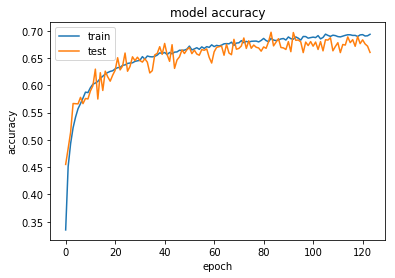

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
folder_name = "cifar_10"
f = open('./data_set/'+folder_name+'/test_batch', 'rb')
data_dict = pickle.load(f, encoding='latin1')
test_data_X, test_data_Y = data_dict["data"], data_dict["labels"]

test_data_X = test_data_X.reshape(test_data_X.shape[0], 3, 32, 32)
test_data_X = test_data_X.transpose(0, 2, 3, 1) 
test_data_X = test_data_X.astype('float32')
test_data_X /= 255
test_data_X -= datagen.mean
test_data_X /= (datagen.std + 1e-07)

In [14]:
# test_data_Y = np.reshape(test_data_Y, (len(test_data_Y), 1))
# test_data_Y = to_categorical(test_data_Y, 10)

In [15]:
from keras.models import load_model
max_val_acc = max(history.history["val_acc"])
file_name = "val_acc_" + ("%.4f" % (max_val_acc))
file_name = "./model_save/" + file_name
final_model = load_model("{}.hdf5".format(file_name))

In [16]:
def inverse_category_predict(anumpy):
    return anumpy.tolist().index(max(anumpy))

In [17]:
result = final_model.predict(test_data_X)

In [20]:
pred_Y = list() 
for elem in result: pred_Y.append(inverse_category_predict(elem)) 

In [23]:
from sklearn.metrics import accuracy_score

score = accuracy_score(test_data_Y, pred_Y)
print("Test Acc: ", score * 100, "%")

Test Acc:  69.19 %
